In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# 1. Data Loading and Preprocessing
def load_and_preprocess_data():
    # For demonstration, we'll create a synthetic dataset
    # In practice, replace this with your actual dataset
    from sklearn.datasets import make_regression
    X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=42)
    
    # Convert to DataFrame for easier handling
    X = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
    y = pd.Series(y, name='target')
    
    # Handle missing values (if any)
    X = X.fillna(X.mean())
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    
    return X_scaled, y

In [11]:
# 2. Feature Selection
def select_features(X, y):
    # Use GradientBoostingRegressor for feature importance
    gbr = GradientBoostingRegressor(random_state=42)
    gbr.fit(X, y)
    
    # Select features based on importance
    selector = SelectFromModel(gbr, threshold='median')
    selector.fit(X, y)
    
    # Get selected feature names
    selected_features = X.columns[selector.get_support()].tolist()
    
    print(f"Selected features: {selected_features}")
    return X[selected_features], selected_features

In [12]:
# 3. Hyperparameter Tuning
def tune_hyperparameters(X, y):
    # Define parameter grid
    param_grid = {
        'n_estimators': [10, 20, 30],
        'learning_rate': [0.1, 0.05, 0.2],
        'max_depth': [3, 4, 5],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    
    # Initialize model
    gbr = GradientBoostingRegressor(random_state=42)
    
    # Perform grid search
    grid_search = GridSearchCV(
        estimator=gbr,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    grid_search.fit(X, y)
    
    print(f"Best parameters: {grid_search.best_params_}")
    return grid_search.best_estimator_

In [13]:
# 4. Model Training and Evaluation
def train_and_evaluate_model(X, y, selected_features):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Train model with best parameters
    model = tune_hyperparameters(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R2 Score: {r2:.4f}")
    
    # Cross-validation
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    print(f"Cross-validation R2 scores: {cv_scores}")
    print(f"Average CV R2 score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    # Feature importance visualization
    feature_importance = pd.DataFrame({
        'feature': selected_features,
        'importance': model.feature_importances_
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()
    
    return model

In [14]:
# 5. Main execution
def main():
    # Load and preprocess data
    X, y = load_and_preprocess_data()
    
    # Feature selection
    X_selected, selected_features = select_features(X, y)
    
    # Train and evaluate model
    model = train_and_evaluate_model(X_selected, y, selected_features)
    
    return model

Selected features: ['feature_0', 'feature_1', 'feature_4', 'feature_6', 'feature_9', 'feature_10', 'feature_11', 'feature_15', 'feature_17', 'feature_18']
Best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 30}
Mean Squared Error: 4340.7412
R2 Score: 0.8879
Cross-validation R2 scores: [0.90958559 0.85785094 0.8719139  0.87036444 0.82297603]
Average CV R2 score: 0.8665 (+/- 0.0556)


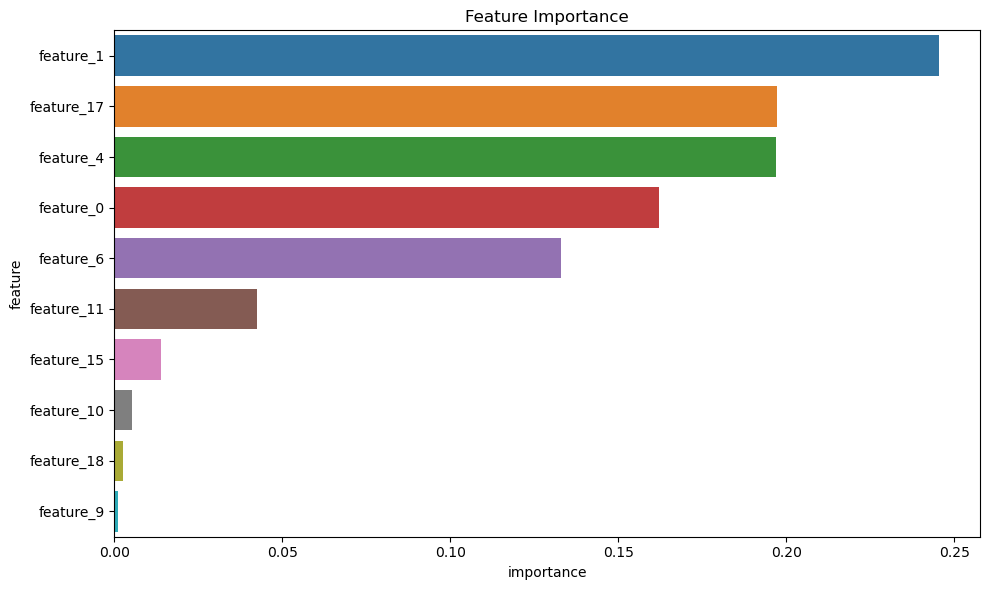

In [15]:
if __name__ == "__main__":
    model = main()